In [1]:
# KoBART summarization Model

import torch
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

# huggingface에 이미 학습이 된 모델과 tokenizer를 불러옴
tokenizer = PreTrainedTokenizerFast.from_pretrained('digit82/kobart-summarization')
model = BartForConditionalGeneration.from_pretrained('digit82/kobart-summarization')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/682k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/109 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

In [11]:
import pandas as pd

curr_df = pd.read_csv('cleaned_2015-2019_한국경제.csv')

In [12]:
curr_df.shape

(30057, 13)

In [13]:
curr_df.head()

,Unnamed: 0,index,link,date,title,body,year,month,day,hour,minute,cleaned_title,cleaned_body
0,0.0,2015000001,https://n.news.naver.com/mnews/article/015/000...,2015-01-01 03:31:00,乙未4변…을미년 점검해야 할 4대 변수,"2015 증시 전망미국, 금리인상 앞두고 强달러 지속…외국인 매도 이어질지 살펴봐야...",2015,1,1,3,31,을미 4변을 미년 점검해야 할 4대 변수.,"2015 증시 전망 미국, 금리 인상 앞두고 강 달러 지 속 외국인 매도 이어질지 ..."
1,1.0,2015000002,https://n.news.naver.com/mnews/article/015/000...,2015-01-01 03:31:00,"조성진 사장, CES 참석하나…검찰, 출국금지 해제 검토","""CES 개막 전 재소환""[ 정소람 / 남윤선 기자 ] ‘삼성전자 세탁기 파손 의혹...",2015,1,1,3,31,"조성진 사장, 참석하나 검찰, 출국금지 해제 검토.",""" 개막 전 재소환"" 삼성전자 세탁기 파손 의혹 사건을 수사 중인 검찰은 조성진 홈..."
2,2.0,2015000003,https://n.news.naver.com/mnews/article/015/000...,2015-01-01 03:31:00,[다시 도전이다] 세계경제포럼 선정 '10대 유망 기술',한계돌파 (上) 세계시장에 기회 있다웨어러블·빅데이터·사물인터넷…[ 이미아 기자 ]...,2015,1,1,3,31,세계 경제포럼 선정 '10대 유망 기술'.,한계 돌파 상 세계시장에 기회 있다웨어러블 빅데이터 사물인터넷 세계 시장을 주도 할...
3,3.0,2015000004,https://n.news.naver.com/mnews/article/015/000...,2015-01-01 03:31:00,"삼성, 밀크VR 美 출시…가상현실 서비스 강화",[ 남윤선 기자 ] 삼성전자가 밀크 브랜드를 앞세워 소프트웨어 서비스를 강화하고 있...,2015,1,1,3,31,"삼성, 밀크 미 출시가 상현실 서비스 강화.",삼성전자가 밀크 브랜드를 앞세워 소프트웨어 서비스를 강화하고. 이번엔 기어 사용자를...
4,4.0,2015000005,https://n.news.naver.com/mnews/article/015/000...,2015-01-01 03:31:00,새해 뮤지컬 시장에 따끈한 大作 쏟아진다,오는 9일 서울 예술의전당에서 개막하는 뮤지컬 '바람과 함께 사라지다'의 주인공 임...,2015,1,1,3,31,새해 뮤지컬 시장에 따끈한 대작 쏟아진다.,오는 9일 서울 예술의전당에서 개막하는 뮤지컬 '바람과 사라지다'의 주인공 임태경 ...


39381


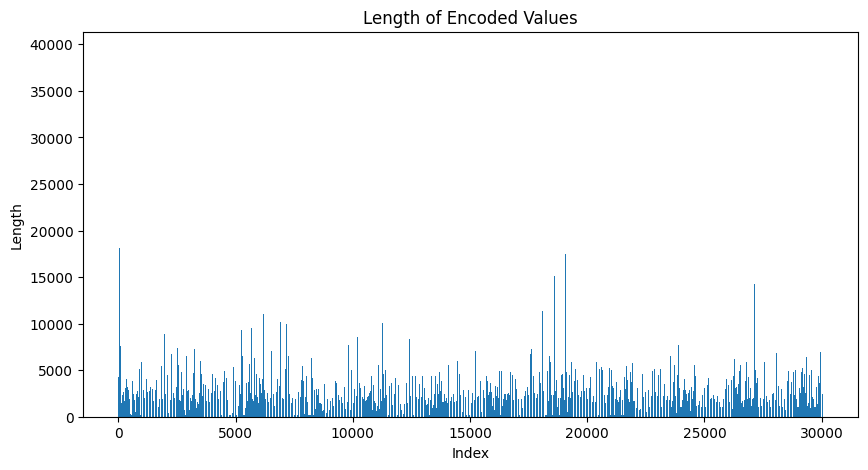

In [14]:
import matplotlib.pyplot as plt

encoded_values = curr_df['body'].dropna().apply(lambda x: x.encode('utf-8') if isinstance(x, str) else None).tolist()

length = []

for value in encoded_values:
    length.append(len(value))

print(max(length))

plt.figure(figsize=(10, 5))
plt.bar(range(len(length)), length)
plt.xlabel('Index')
plt.ylabel('Length')
plt.title('Length of Encoded Values')
plt.show()

In [15]:
# 요약 모델을 포함한 함수 -> 이 함수를 사용하면 본문이 요약됨

def summarizer(text):
    # 문서를 토큰화(encode해줌)
    raw_input_ids = tokenizer.encode(text)
    # 입력을 넣어줄때 맨 앞에 bos토큰, 맨 뒤에 eos토큰을 추가하여 모델이 입력단위를 알아보게 함
    input_ids = [tokenizer.bos_token_id] + raw_input_ids[:1022] + [tokenizer.eos_token_id]
    # 모들은 최대 1024까지 받을 수 있어서  raw_input_ids[:1022]로 설정.

    # 요약 : 모델 추론과정
    summarized_ids = model.generate(torch.tensor([input_ids]),
                                    num_beams=4,
                                    max_length=1024) # # 모들은 최대 1024까지 받을 수 있음과 동일한 맥락
    # 토큰을 다시 인간이 알아볼 수 있는 자연어로 decode해줌
    summarized_text = tokenizer.decode(summarized_ids.squeeze().tolist(),
                                       skip_special_tokens=True)

    return summarized_text

In [ ]:
# curr_df['cleaned_body']의 value들을 요약하여 curr_df['summarized_body']로 추가
curr_df['summarized_body'] = curr_df['cleaned_body'].apply( summarizer )

In [ ]:
curr_df

In [ ]:
print(curr_df['summarized_body'][1])
print('--')
print(curr_df['summarized_body'][2])
print('--')
print(curr_df['summarized_body'][3])
print('--')
print(curr_df['summarized_body'][4])
print('--')
print(curr_df['summarized_body'][5])

In [ ]:
curr_df.to_csv('summarized_cleaned_2015-2019_한국경제.csv',
               index=False,
               encoding='utf-8')